SET PARAMETERS

In [1]:
# initialize params
DEBUG = True
saveReport = False
toPrint = True
reportName = 'notebook'
txt_label = "Classification of integrated c1 and c2 CNVs samples"
sample_class_column = "Relapsed"
class_labels = ["relapsed","NOTrelapsed"]
class_values = [1,0]

# classification params
split_train_size = 20
split_random_state = 0

# plotting params
plot_kwargs = {}
function_dict = None
with_swarm = False
highRes = False
if highRes:
    img_ext = '.pdf'
else:
    img_ext = '.png'
cmap_custom = None
vmin, vmax = (-2, +2)

In [16]:
# file paths
data_fpath = "output/headneck/integrate_cohorts/c1c2/CNV_mapped_filt/integrated_data.csv"

test_fpath = "output/headneck/feature_selection/c1_prmr_OncFltNxEx/sample_prediciton_scores.csv"

cnv_feature_fpaths = [
    "output/headneck/feature_selection/c1_prmr_OncFltNxEx/featsel_results.csv",
    "output/headneck/feature_selection/c2_ExcvFltNxEx/featsel_results.csv",
    "output/headneck/feature_selection/c1_prmr_mapped_c2_CnvFltNxEx/featsel_results.csv",
]

snv_feature_fpaths = [
    "output/headneck/setup_c1_genepanel/process_select_primary/data_processed.csv",
]

mixed_feature_fpaths = [
    "output/headneck/feature_selection/c1_prmr_GnPn_OncFltNxEx/featsel_results.csv",
]

sample_info_fpath = "input/headneck/integrate_cohorts/integrated_sample_info.csv"
gene_info_fpath = "input/headneck/integrate_cohorts/gene_info.csv"
output_directory = "output/headneck/classification"

sample_info_read_csv_kwargs = {
    "sep": "\t",
    "header": 0,
    "index_col": 0,
    "col_as_index":"cnvID"
}

SET ENVIRONMENT

In [3]:
# custom imports
from omics_processing.io import (
    set_directory, load_clinical
)
from omics_processing.remove_duplicates import (
    remove_andSave_duplicates
)
from gene_signatures.core import (
    custom_div_cmap,
    get_chr_ticks,
    choose_samples,
    parse_arg_type,
    boxplot,
    set_heatmap_size,
    set_cbar_ticks,
    edit_names_with_duplicates
)

# basic imports
import os, sys
import numpy as np
import pandas as pd
import json
from scipy.spatial.distance import pdist, squareform
from natsort import natsorted, index_natsorted
import math
import logging
from sklearn import linear_model
from sklearn import svm
from distutils.util import strtobool
from scipy.stats import binom_test
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split

# plotting imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

script_path = os.getcwd()
logger = logging.getLogger(__name__)

START ANALYSIS

In [4]:
if DEBUG:
    logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [17]:
# properly set file paths
try:
    os.path.exists(MainDataDir)
except:
    MainDataDir = os.path.join(script_path, '..','..', 'data')
    logger.debug("set MainDataDir:\n"+MainDataDir)

# data input
if not os.path.exists(data_fpath):
    data_fpath = os.path.join(*data_fpath.rsplit('/'))
    data_fpath = os.path.join(MainDataDir, data_fpath)
    logger.debug("set data_fpath:\n"+data_fpath)

# test input
if not os.path.exists(test_fpath):
    test_fpath = os.path.join(*test_fpath.rsplit('/'))
    test_fpath = os.path.join(MainDataDir, test_fpath)
    logger.debug("set data_fpath:\n"+test_fpath)
    
# sample info input
if not os.path.exists(sample_info_fpath):
    sample_info_fpath = os.path.join(*sample_info_fpath.rsplit('/'))
    sample_info_fpath = os.path.join(MainDataDir, sample_info_fpath)
    logger.debug("set sample_info_fpath:\n"+sample_info_fpath)

# gene info input
if not os.path.exists(gene_info_fpath):
    gene_info_fpath = os.path.join(*gene_info_fpath.rsplit('/'))
    gene_info_fpath = os.path.join(MainDataDir, gene_info_fpath)
    logger.debug("set gene_info_fpath:\n"+gene_info_fpath)

# data output
if not os.path.exists(output_directory):
    output_directory = os.path.join(*output_directory.rsplit('/'))
    output_directory = set_directory(
        os.path.join(MainDataDir, output_directory, reportName)
    )
    logger.debug("set output_directory:\n"+output_directory)

DEBUG:__main__:set data_fpath:
/Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/output/headneck/integrate_cohorts/c1c2/CNV_mapped_filt/integrated_data.csv
DEBUG:__main__:set data_fpath:
/Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/output/headneck/feature_selection/c1_prmr_OncFltNxEx/sample_prediciton_scores.csv
DEBUG:__main__:set sample_info_fpath:
/Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/input/headneck/integrate_cohorts/integrated_sample_info.csv
DEBUG:__main__:set gene_info_fpath:
/Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/input/headneck/integrate_cohorts/gene_info.csv
DEBUG:__main__:set output_directory:
/Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/output/headneck/classification/notebook


In [9]:
if (cmap_custom is None) and (vmin is not None) and (vmax is not None):
    custom_div_cmap_arg = abs(vmin)+abs(vmax)
    if (vmin <= 0) and (vmax >= 0):
        custom_div_cmap_arg = custom_div_cmap_arg + 1
    mincol = plot_kwargs.get('mincol', None)
    midcol = plot_kwargs.get('midcol', None)
    maxcol = plot_kwargs.get('maxcol', None)
    if (
            (mincol is not None) and
            (midcol is not None) and
            (maxcol is not None)
            ):
        cmap_custom = custom_div_cmap(
            numcolors=custom_div_cmap_arg,
            mincol=mincol, midcol=midcol, maxcol=maxcol)
    else:
        cmap_custom = custom_div_cmap(numcolors=custom_div_cmap_arg)

In [10]:
# load data
data = pd.read_csv(data_fpath, sep='\t', header=0, index_col=0)
logger.info('loaded data file with shape: '+str(data.shape))

INFO:__main__:loaded data file with shape: (71, 18530)


In [18]:
# load test
test = pd.read_csv(test_fpath, sep='\t', header=0, index_col=0)
logger.info('loaded test file with shape: '+str(test.shape))

INFO:__main__:loaded test file with shape: (21, 2)


In [62]:
test.head()

,Ccode,pred_diffs
cnvID,,
DS-101_0001,0,1.0
DS-101_0007,0,0.0
DS-101_0009,0,0.0
DS-101_0011,0,0.0
DS-101_0013,0,1.0


In [36]:
test.sum(axis=0)

Ccode         11.0
pred_diffs     3.0
dtype: float64

In [37]:
test[test.Ccode == 0].sum(axis=0)

Ccode         0.0
pred_diffs    3.0
dtype: float64

In [136]:
test.astype(int)

,Ccode,pred_diffs
cnvID,,
DS-101_0001,0,1
DS-101_0007,0,0
DS-101_0009,0,0
DS-101_0011,0,0
DS-101_0013,0,1
DS-101_0015,0,0
DS-101_0017,0,0
DS-101_0019,0,0
DS-101_0021,0,1


In [135]:
[class_labels[class_values==0][0],class_labels[class_values==1][0]]

['NOrelapse', 'relapse']

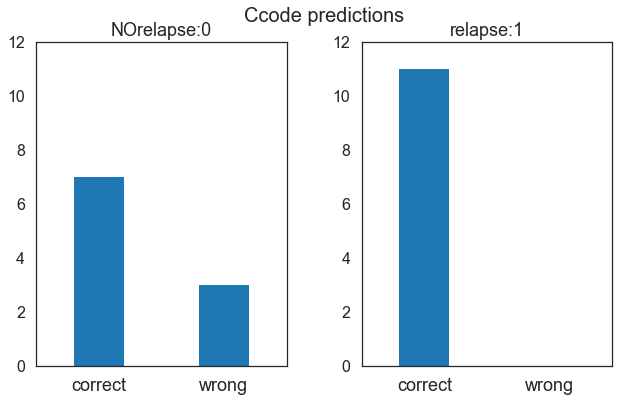

In [110]:
sample_class_column = "Ccode"
class_labels = np.array(["relapse","NOrelapse"])
class_values = np.array([1,0])

y_maxlim = np.histogram(test[sample_class_column], bins=2)[0].max()
axes = test.hist(by = 'Ccode', column='pred_diffs', bins=2, rwidth=0.4,figsize=(10,6))
for ax in axes:
    ax.set_ylim(0,y_maxlim+1)
    ax.set_xlim(0,1)
    ax.set_xticks([0.25,0.75])
    ax.set_xticklabels(['correct','wrong'], rotation=0,fontsize=18)
    ax_title = class_labels[np.where(class_values==float(ax.get_title()))[0][0]]+':'+str(ax.get_title())
    ax.set_title(ax_title,fontsize=18)
    plt.suptitle(sample_class_column+' predictions', fontsize=20)

In [121]:
from sklearn.metrics import confusion_matrix
import itertools

In [122]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.7 0.3]
 [0.  1. ]]


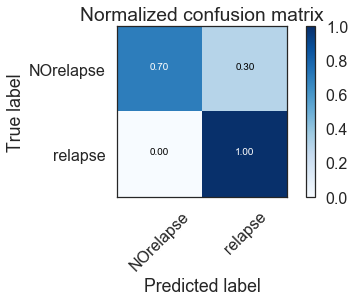

In [128]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test[sample_class_column], np.abs(test[sample_class_column]-test['pred_diffs']))
np.set_printoptions(precision=2)
_classes = [class_labels[class_values==0][0],class_labels[class_values==1][0]]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=_classes, normalize=True,
                      title='Normalized confusion matrix')

In [97]:
class_labels[np.where(class_values==1)[0][0]]

'relapse'

In [89]:
class_values

[1, 0]

In [ ]:
# load info table of samples
sample_info = load_clinical(
    sample_info_fpath, **sample_info_read_csv_kwargs)
logger.info('loaded sample_info file with shape: '+str(sample_info.shape))

In [ ]:
# load info table of genes
gene_info = pd.read_csv(gene_info_fpath, sep='\t', header=0, index_col=0)
logger.info('loaded gene_info file with shape: '+str(gene_info.shape))

In [ ]:
# set the ground truth
ground_truth = sample_info.loc[data.index, sample_class_column]